### Grain classification - End-to-end training and evaluation (PyTorch)

This notebook trains a classifier on either:
- RGB dataset at `data/Grain-Data-RGB`
- HSI dataset at `data/Grain-Data` (converted to 3 channels via selected bands)

Includes:
- On-the-fly `.npz` loading and transforms
- Stratified train/val split
- ResNet18 training (no pretrained weights by default)
- Evaluation: accuracy, macro F1, confusion matrix
- Saving weights and label mapping

In [ ]:
# Using pure PyTorch only (no torchvision)
print("Using pure PyTorch (no torchvision).")

matplotlib                3.10.0
matplotlib-inline         0.1.6
numpy                     2.0.1
torch                     2.9.1
torchvision               0.24.1


In [23]:
# Imports & config
import os, math, random, json
from typing import List, Tuple, Dict
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

# Paths and options
DATASET_KIND = 'rgb'  # 'rgb' or 'hsi'
GRAIN_DATA = "/home/moujar/dev/Grain-Challenge-M1-AI/data/Grain-Data"
GRAIN_DATA_RGB = "/home/moujar/dev/Grain-Challenge-M1-AI/data/Grain-Data-RGB"
OUTPUT_DIR = "/home/moujar/dev/Grain-Challenge-M1-AI/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
IMAGE_SIZE = 224  # resize input to this size
VAL_FRACTION = 0.15

# Sampling limits for speed (set to None for full dataset)
MAX_FILES_TOTAL = 10000 if DATASET_KIND == 'rgb' else 800
MAX_FILES_PER_CLASS = 800 if DATASET_KIND == 'rgb' else 120

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


In [20]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.2 MB/s  0:00:01m 6.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 9.1 MB/s  0:00:04m 9.2 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]


In [24]:
# File listing and label extraction

def list_npz_files(folder: str) -> List[str]:
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npz')]
    files.sort()
    return files


def read_label(npz_path: str) -> str:
    with np.load(npz_path, allow_pickle=False) as data:
        y = data['y']
        return str(y.tolist() if y.shape == () else y)


def build_label_mapping(files: List[str]) -> Tuple[Dict[str,int], Dict[int,str]]:
    labels = sorted({read_label(f) for f in files})
    label_to_index = {lbl: i for i, lbl in enumerate(labels)}
    index_to_label = {i: lbl for lbl, i in label_to_index.items()}
    return label_to_index, index_to_label


def stratified_split(files: List[str], val_fraction: float, max_total: int | None, max_per_class: int | None) -> Tuple[List[str], List[str]]:
    rng = np.random.default_rng(RANDOM_SEED)
    by_label: Dict[str, List[str]] = {}
    for f in files:
        lbl = read_label(f)
        by_label.setdefault(lbl, []).append(f)
    train, val = [], []
    for lbl, flist in by_label.items():
        rng.shuffle(flist)
        if max_per_class is not None:
            flist = flist[:max_per_class]
        k_val = max(1, int(len(flist) * val_fraction))
        val.extend(flist[:k_val])
        train.extend(flist[k_val:])
    rng.shuffle(train)
    rng.shuffle(val)
    if max_total is not None:
        train = train[: max(1, int(max_total * (1.0 - val_fraction)))]
        val = val[: max(1, int(max_total * val_fraction))]
    return train, val

RGB_FILES = list_npz_files(GRAIN_DATA_RGB)
HSI_FILES = list_npz_files(GRAIN_DATA)
print('RGB files:', len(RGB_FILES), 'HSI files:', len(HSI_FILES))

RGB files: 26882 HSI files: 2400


In [25]:
# Dataset and transforms (no torchvision)

class GrainNPZDataset(Dataset):
    def __init__(self, files: List[str], label_to_index: Dict[str, int], kind: str, image_size: int = 224):
        assert kind in ('rgb', 'hsi')
        self.files = files
        self.label_to_index = label_to_index
        self.kind = kind
        self.image_size = image_size

    def __len__(self) -> int:
        return len(self.files)

    def _load_rgb(self, path: str) -> Tuple[np.ndarray, int]:
        with np.load(path, allow_pickle=False) as data:
            x = data['x']  # (H,W,3), int16
            y = data['y']
            label_str = str(y.tolist() if y.shape == () else y)
        label_idx = self.label_to_index[label_str]
        # Min-max per-image stretch to [0,1]
        x = x.astype(np.float32)
        lo, hi = np.percentile(x, 2.0), np.percentile(x, 98.0)
        if hi <= lo: hi = lo + 1.0
        x = np.clip((x - lo) / (hi - lo), 0.0, 1.0)
        return x, label_idx

    def _load_hsi(self, path: str) -> Tuple[np.ndarray, int]:
        with np.load(path, allow_pickle=False, mmap_mode='r') as data:
            X = data['X']  # (H,W,B)
            y = data['y']
            label_str = str(y.tolist() if y.shape == () else y)
        label_idx = self.label_to_index[label_str]
        # Select 3 bands for false-color composite (fast path)
        H, W, B = X.shape
        b = (20, 60, 100)
        b = tuple(int(max(0, min(B-1, i))) for i in b)
        rgb = np.stack([X[:,:,b[0]], X[:,:,b[1]], X[:,:,b[2]]], axis=-1).astype(np.float32)
        lo, hi = np.percentile(rgb, 2.0), np.percentile(rgb, 98.0)
        if hi <= lo: hi = lo + 1.0
        rgb = np.clip((rgb - lo) / (hi - lo), 0.0, 1.0)
        return rgb, label_idx

    def _to_tensor_and_resize(self, img_np: np.ndarray) -> torch.Tensor:
        # HWC float[0,1] -> CHW float tensor resized to image_size
        t = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0)  # (1,C,H,W)
        t = F.interpolate(t, size=(self.image_size, self.image_size), mode='bilinear', align_corners=False)
        return t.squeeze(0)

    def __getitem__(self, idx: int):
        path = self.files[idx]
        if self.kind == 'rgb':
            img_np, label = self._load_rgb(path)
        else:
            img_np, label = self._load_hsi(path)
        img = self._to_tensor_and_resize(img_np)
        return img, label

In [26]:
# Build splits and dataloaders

FILES = RGB_FILES if DATASET_KIND == 'rgb' else HSI_FILES
assert len(FILES) > 0, "No files found"

# Build label mapping on the chosen dataset
label_to_index, index_to_label = build_label_mapping(FILES)
NUM_CLASSES = len(label_to_index)
print('Classes:', NUM_CLASSES, index_to_label)

# Split
train_files, val_files = stratified_split(
    FILES, val_fraction=VAL_FRACTION,
    max_total=MAX_FILES_TOTAL, max_per_class=MAX_FILES_PER_CLASS,
)
print('Train/Val sizes:', len(train_files), len(val_files))

# Datasets
train_ds = GrainNPZDataset(train_files, label_to_index, kind=DATASET_KIND, image_size=IMAGE_SIZE)
val_ds   = GrainNPZDataset(val_files,   label_to_index, kind=DATASET_KIND, image_size=IMAGE_SIZE)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Classes: 8 {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8'}
Train/Val sizes: 5440 960


In [28]:
# Model definition (no torchvision) + minimal SGD optimizer (no torch.optim)

class SmallConvNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class SGDLike:
    def __init__(self, params, lr: float = 1e-3):
        self.params = [p for p in params if p.requires_grad]
        self.lr = float(lr)
    def zero_grad(self, set_to_none: bool = False):
        for p in self.params:
            if p.grad is not None:
                if set_to_none:
                    p.grad = None
                else:
                    p.grad.detach_()
                    p.grad.zero_()
    def step(self):
        for p in self.params:
            if p.grad is not None:
                p.data.add_(p.grad, alpha=-self.lr)

model = SmallConvNet(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = SGDLike(model.parameters(), lr=LEARNING_RATE)

print(model.__class__.__name__, 'params:', sum(p.numel() for p in model.parameters()) )

SmallConvNet params: 94728


Epoch 01/5 | train_loss=2.0811 acc=0.125 | val_loss=2.0759 acc=0.124
Epoch 02/5 | train_loss=2.0742 acc=0.126 | val_loss=2.0703 acc=0.143
Epoch 03/5 | train_loss=2.0696 acc=0.148 | val_loss=2.0659 acc=0.170
Epoch 04/5 | train_loss=2.0663 acc=0.169 | val_loss=2.0624 acc=0.192
Epoch 05/5 | train_loss=2.0632 acc=0.176 | val_loss=2.0592 acc=0.199


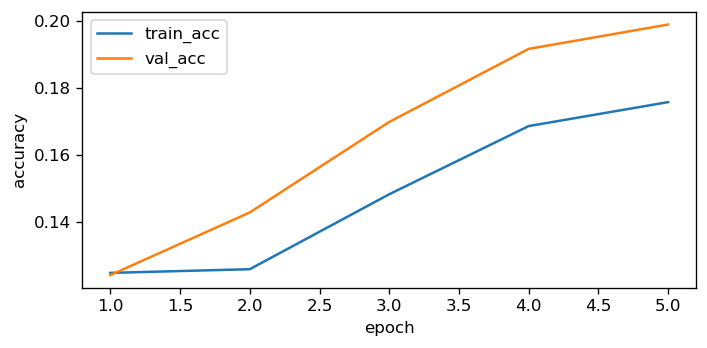

In [29]:
# Training & validation

def run_epoch(dataloader: DataLoader, model: nn.Module, criterion, optimizer=None) -> Tuple[float, float]:
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in dataloader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            loss = criterion(outputs, targets)
            if is_train:
                loss.backward()
                optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    avg_loss = running_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc

best_val_acc = 0.0
history = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, criterion, optimizer=None)
    history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
    })
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.3f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.3f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state_dict': model.state_dict()}, os.path.join(OUTPUT_DIR, f'best_{DATASET_KIND}.pt'))

# Plot training curve
plt.figure(figsize=(6,3))
plt.plot([h['epoch'] for h in history], [h['train_acc'] for h in history], label='train_acc')
plt.plot([h['epoch'] for h in history], [h['val_acc'] for h in history], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.tight_layout(); plt.show()

              precision    recall  f1-score   support

           1       0.38      0.03      0.05       120
           2       0.29      0.17      0.22       120
           3       0.21      0.37      0.26       120
           4       0.25      0.02      0.03       120
           5       0.00      0.00      0.00       120
           6       0.30      0.03      0.05       120
           7       0.20      0.72      0.31       120
           8       0.15      0.26      0.19       120

    accuracy                           0.20       960
   macro avg       0.22      0.20      0.14       960
weighted avg       0.22      0.20      0.14       960



/home/moujar/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/moujar/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/moujar/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

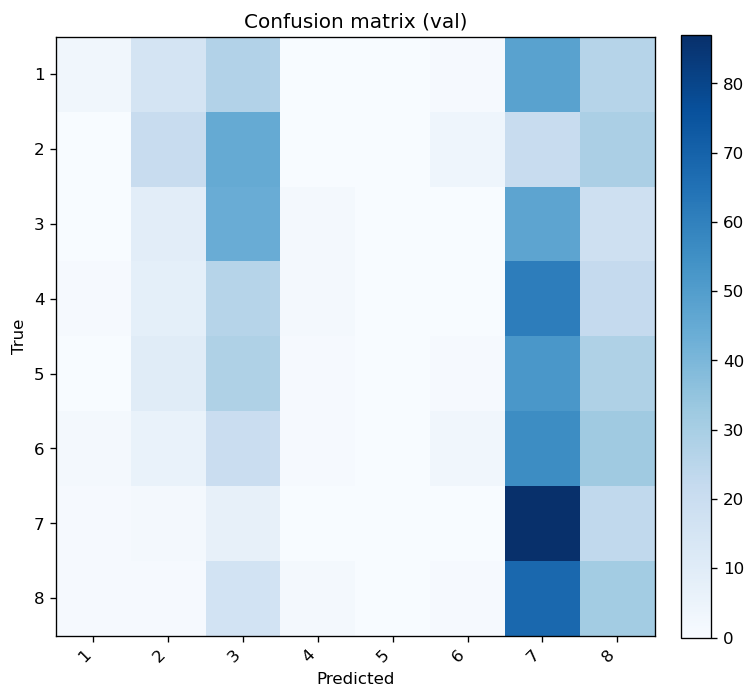

Validation metrics: {'accuracy': 0.19895833333333332, 'f1_macro': 0.13830715551958903}


In [32]:
# Evaluation metrics and confusion matrix

def evaluate_loader(dataloader: DataLoader, model: nn.Module) -> Dict[str, float]:
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(images)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    acc = float((y_pred == y_true).mean())
    result = {"accuracy": acc}
    if f1_score is not None:
        try:
            result["f1_macro"] = float(f1_score(y_true, y_pred, average='macro'))
            print(classification_report(y_true, y_pred, target_names=[index_to_label[i] for i in range(NUM_CLASSES)]))
        except Exception:
            pass
    # Confusion matrix
    if confusion_matrix is not None:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    else:
        cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
        for t, p in zip(y_true, y_pred):
            cm[t, p] += 1
    fig, ax = plt.subplots(figsize=(4 + NUM_CLASSES*0.3, 4 + NUM_CLASSES*0.3))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(NUM_CLASSES)); ax.set_xticklabels([index_to_label[i] for i in range(NUM_CLASSES)], rotation=45, ha='right')
    ax.set_yticks(range(NUM_CLASSES)); ax.set_yticklabels([index_to_label[i] for i in range(NUM_CLASSES)])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.title('Confusion matrix (val)')
    plt.tight_layout(); plt.show()
    return result

metrics = evaluate_loader(val_loader, model)
print('Validation metrics:', metrics)

In [33]:
# Save artifacts (best checkpoint saved during training)
label_map_path = os.path.join(OUTPUT_DIR, f'labels_{DATASET_KIND}.json')
with open(label_map_path, 'w') as f:
    json.dump({"label_to_index": label_to_index, "index_to_label": index_to_label}, f, indent=2)
print('Saved label mapping to', label_map_path)

# Export final model as well
final_path = os.path.join(OUTPUT_DIR, f'final_{DATASET_KIND}.pt')
torch.save({'model_state_dict': model.state_dict()}, final_path)
print('Saved final model to', final_path)

Saved label mapping to /home/moujar/dev/Grain-Challenge-M1-AI/models/labels_rgb.json
Saved final model to /home/moujar/dev/Grain-Challenge-M1-AI/models/final_rgb.pt
